In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [2]:
objective = 'byte_hit_rate'
fig_dir = '/data/zhenyus/webcachesim/notebook/figures/'

In [3]:
def get_linestyle(alg):
    if alg == 'Belady':
        return '--'
    else:
        return '-'

In [4]:
marker_map = {
    'Belady': '1',
    'S4LRU': 'd',
    'LFUDA': 'o',
    'LFU': 'o',
    'Adaptive-TinyLFU': 'v',
#     'BeladySample': '#000080',
    'GDBT': '*',
#     'LR': 'r',
    'LRUK': '>',
    
    'GDSF': '8',
    'LRU': 's',
    'FIFO': 's',
    
#     'Hyperbolic': 'chartreuse',
    'LeCaR': 'p',
    'AdaptSize': 'P',
    'LHD': '+',
    'GDWheel': 'x',
    
}

In [5]:
color_map = {
    'Belady': 'k',
#     'BeladySample': '#000080',
    'GDBT': 'b',
#     'LR': 'r',
    'LRUK': 'g',
    'FIFO': 'r',
    'LFUDA': '#808080',
#     'GDSF': 'm',
    'LRU': 'm',
    'LFU': '#808080',
    'S4LRU': '#FC0FC0',
    'LHD': 'r',
#     'Hyperbolic': 'chartreuse',
    'LeCaR': '#ed740b',
#     'AdaptSize': '#669999',

#     'GDWheel': '#000080',
    'Adaptive-TinyLFU': 'burlywood',
}

In [6]:
trace_map = {
    'wc200m.tr': 'Wikipedia',
    'wc400m.tr': 'Wikipedia',
    'traceHK.tr': 'CDN Asia',
    'traceUS.tr': 'CDN East Cost',
    'memc_200m.tr': 'Memcachier',
    'msr_rehash_200m.tr': 'MSR Storage',
    'anonymous_200m.tr': 'Anonymous Application',
    'caida_cache_200m.tr': 'Caida',
}

In [244]:
def label_map(alg):
    if alg == 'Adaptive-TinyLFU':
        return 'TinyLFU'
    elif alg == 'GDBT':
        return 'WLC'
    return alg

In [8]:
def cache_type_to_color(s: str):
    if s in color_map:
        return color_map[s]
    raise Exception(f'color {s} is not defined in color map')

In [9]:
trace_cache_sizes = {
    'traceHK.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'traceUS.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'wc400m.tr': {
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'memc_200m.tr':{
        67108864,
        134217728,
        268435456,
        536870912,
        1073741824,
        2147483648,
        4294967296,
        8589934592,
    },
    'msr_rehash_200m.tr':{
        4294967296,
        8589934592,
        17179869184,
        34359738368,
        68719476736,
        137438953472,
        274877906944,
        549755813888,
    },
    'anonymous_200m.tr': {
        268435456,
        536870912,
        1073741824,
        2147483648,
        4294967296,
        8589934592,
        17179869184,
        34359738368,
    },
}

In [10]:
def top_algorithm_all_trace_csizes(df, objective='byte_hit_rate', k=4):
    top_algs = set()
    df1 = df[~df.cache_type.isin(['GDBT', 'Belady'])].groupby(['trace_file', 'cache_type', 'cache_size'])\
       .agg({objective: 'max'}).reset_index().groupby(['cache_size', 'trace_file'])
    for l, grp in df1:
        top_alg = set(grp.sort_values(by=[objective],  ascending=False).cache_type[0:k])
        top_algs = top_algs.union(top_alg)
    return top_algs

In [11]:
# globally refresh
df = common.load_reports()

In [245]:
# find top algorithms

filter_idx = (
    (df.trace_file == 'traceHK.tr') 
    & (df.uni_size == 0)
    & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR', 'LFU']))
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.cache_size.isin(trace_cache_sizes['traceHK.tr']))
    & (df.n_warmup == 80000000)
) | ((df.trace_file == 'traceUS.tr') 
    & (df.uni_size == 0)
    & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR', 'LFU'])) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.cache_size.isin(trace_cache_sizes['traceUS.tr']))
    & (df.n_warmup == 100000000)
) | (
    (df.trace_file == 'wc400m.tr') 
    & (df.uni_size == 0)
    & (~df.cache_type.isin(['Inf', 'BeladySample', 'BeladyTruncate', 'LRU2', 'ThS4LRU', 'ThLRU', 'LR', 'LFU'])) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.cache_size.isin(trace_cache_sizes['wc400m.tr']))
    & (df.n_warmup == 80000000)
)

df1 = df[filter_idx].copy()

In [246]:
top_algs = top_algorithm_all_trace_csizes(df1, k=1)
top_algs

{'Adaptive-TinyLFU', 'LFUDA', 'LRUK', 'LeCaR', 'S4LRU'}

In [247]:
FONT_SIZE = 30
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [248]:
trace = 'wc400m.tr'
scale = 2**30
scale_label = 'GB'

# df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.uni_size == 0)
    & (df.n_warmup == 80000000)
    & (df.cache_size.isin(trace_cache_sizes[trace]))
)

df1 = df[filter_idx].copy()

In [249]:
for l, grp in df1.groupby('cache_size'):
    lru = (1-grp[grp.cache_type == 'LRU'].byte_hit_rate.values[0])
    df1.loc[df1.cache_size == l, 'lru_miss_ratio'] = 100*(lru - (1-df1.loc[df1.cache_size == l, 'byte_hit_rate']))/lru

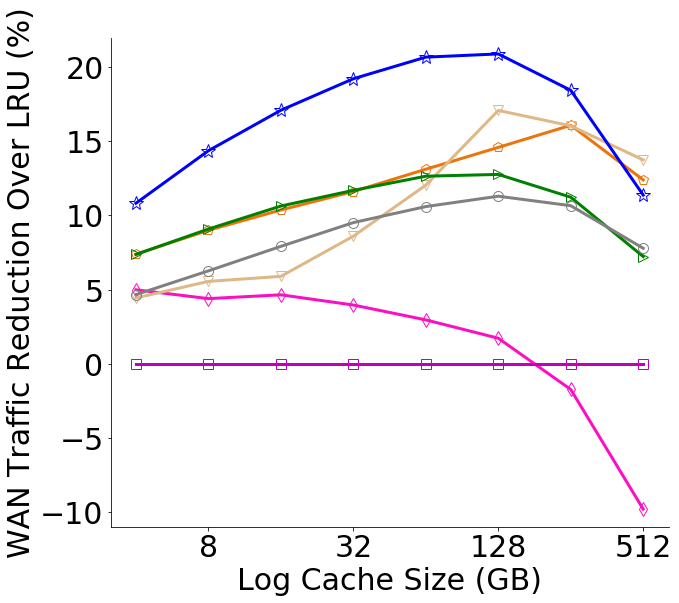

In [250]:
fig, ax = plt.subplots(figsize=(10, 9))
for alg in list(top_algs)+['GDBT', 'LRU']:
    grp = df1[df1.cache_type == alg].groupby('cache_size').agg({'lru_miss_ratio': 'max'}).reset_index()
    grp = grp.sort_values(by=['cache_size'])
    if alg == 'GDBT':
        markersize = 14
    else:
        markersize = 10
    ax.semilogx(grp.cache_size/scale,
              grp.lru_miss_ratio,
              c=cache_type_to_color(alg), 
              label=label_map(alg), 
              marker=marker_map[alg], 
              markersize=markersize,
              markerfacecolor="None",
              linestyle=get_linestyle(alg),
              basex=2)
ax.set_xticks((8, 32, 128, 512))
ax.set_xticklabels(('8', '32', '128', '512')) 
plt.ylim((-11, 22))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Log Cache Size ({scale_label})')
plt.ylabel('WAN Traffic Reduction Over LRU (%)')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.title(trace)
plt.savefig(f"{fig_dir}/evaluation_wiki_rel.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
plt.show()

In [251]:
handles, labels = ax.get_legend_handles_labels()

In [252]:
labels

['S4LRU', 'LeCaR', 'TinyLFU', 'LRUK', 'LFUDA', 'WLC', 'LRU']

In [253]:
permutations = [5, 2, 1, 3, 4, 0, 6]
manual_handles = [handles[i] for i in permutations]
manual_labels = [labels[i] for i in permutations]
manual_labels

['WLC', 'TinyLFU', 'LeCaR', 'LRUK', 'LFUDA', 'S4LRU', 'LRU']

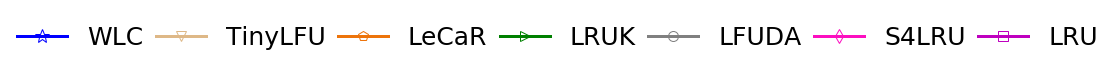

In [254]:
fig_leg, ax_leg = plt.subplots(figsize=(1, 0.1))
legend = plt.figlegend(manual_handles, manual_labels, 
                       ncol=len(list(top_algs)+['GDBT', 'LRU']), 
                       fontsize='small',
                       columnspacing=0.5,
                       loc = 'center',
                       frameon=False
             )
plt.gca().set_axis_off()
plt.savefig(f"{fig_dir}/evaluation_legend_cdn_rel.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0
        )
plt.show()

In [255]:
trace = 'traceHK.tr'
scale = 2**30
scale_label = 'GB'

filter_idx = (
    (df.trace_file == trace) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.uni_size == 0)
    & (df.cache_size.isin(trace_cache_sizes[trace]))
    & (df.n_warmup == 80000000)
)

df1 = df[filter_idx].copy()

In [256]:
for l, grp in df1.groupby('cache_size'):
    lru = (1-grp[grp.cache_type == 'LRU'].byte_hit_rate.values[0])
    df1.loc[df1.cache_size == l, 'lru_miss_ratio'] = 100*(lru - (1-df1.loc[df1.cache_size == l, 'byte_hit_rate']))/lru

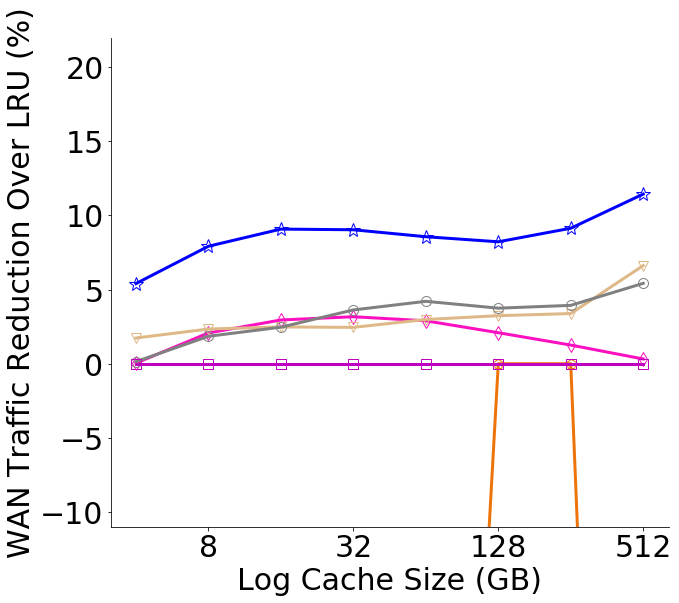

In [257]:
fig, ax = plt.subplots(figsize=(10, 9))
for alg in list(top_algs)+['GDBT', 'LRU']:
    grp = df1[df1.cache_type == alg].groupby('cache_size').agg({'lru_miss_ratio': 'max'}).reset_index()
    grp = grp.sort_values(by=['cache_size'])
    if alg == 'GDBT':
        markersize = 14
    else:
        markersize = 10
    ax.semilogx(grp.cache_size/scale,
              grp.lru_miss_ratio,
              c=cache_type_to_color(alg), 
              label=label_map(alg), 
              marker=marker_map[alg], 
              markersize=markersize,
              markerfacecolor="None",
              linestyle=get_linestyle(alg),
              basex=2)
ax.set_xticks((8, 32, 128, 512))
ax.set_xticklabels(('8', '32', '128', '512')) 
plt.ylim((-11, 22))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Log Cache Size ({scale_label})')
plt.ylabel('WAN Traffic Reduction Over LRU (%)')
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
# plt.title(trace)
plt.savefig(f"{fig_dir}/evaluation_hk_rel.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
plt.show()

In [258]:
trace = 'traceUS.tr'
scale = 2**30
scale_label = 'GB'


filter_idx = (
    (df.trace_file == trace) 
    & ((df.cache_type != 'LRUK') | (df.k =='4'))
    & (df.uni_size == 0)
    & (df.cache_size.isin(trace_cache_sizes[trace]))
    & (df.n_warmup == 100000000)
)

df1 = df[filter_idx].copy()

In [259]:
for l, grp in df1.groupby('cache_size'):
    lru = (1-grp[grp.cache_type == 'LRU'].byte_hit_rate.values[0])
    df1.loc[df1.cache_size == l, 'lru_miss_ratio'] = 100*(lru - (1-df1.loc[df1.cache_size == l, 'byte_hit_rate']))/lru

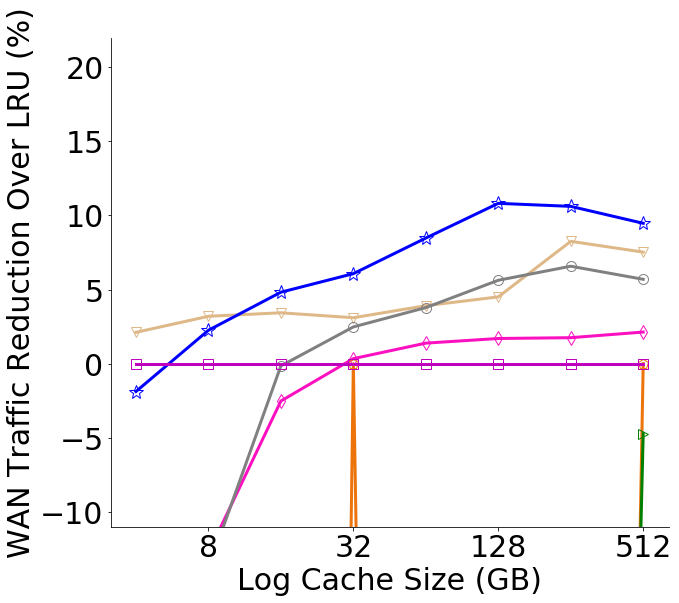

In [260]:
fig, ax = plt.subplots(figsize=(10, 9))
for alg in list(top_algs)+['GDBT', 'LRU']:
    grp = df1[df1.cache_type == alg].groupby('cache_size').agg({'lru_miss_ratio': 'max'}).reset_index()
    grp = grp.sort_values(by=['cache_size'])
    if alg == 'GDBT':
        markersize = 14
    else:
        markersize = 10
    ax.semilogx(grp.cache_size/scale,
              grp.lru_miss_ratio,
              c=cache_type_to_color(alg), 
              label=label_map(alg), 
              marker=marker_map[alg], 
              markersize=markersize,
              markerfacecolor="None",
              linestyle=get_linestyle(alg),
              basex=2)
ax.set_xticks((8, 32, 128, 512))
ax.set_xticklabels(('8', '32', '128', '512')) 
plt.ylim((-11, 22))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Log Cache Size ({scale_label})')
plt.ylabel('WAN Traffic Reduction Over LRU (%)')
# plt.title(trace)
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5)
plt.savefig(f"{fig_dir}/evaluation_us_rel.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
plt.show()